In [ ]:
import re

df = pd.read_csv("data_cleaned.csv")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)          # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()     # normalize whitespace
    return text

df["clean_text"] = df["label"].astype(str).apply(clean_text)

# Debugging print to check if 'clean_text' column exists
print("DataFrame columns after clean_text creation:", df.columns)

# adjust column names if needed
texts = df["clean_text"]
labels = df["status"]

DataFrame columns after clean_text creation: Index(['text', 'label', 'status', 'text_length', 'clean_text'], dtype='object')


In [ ]:
print(df.head())
print(labels.value_counts(normalize=True))


   text                                              label   status  \
0     0                                         oh my gosh  Anxiety   
1     1  trouble sleeping, confused mind, restless hear...  Anxiety   
2     2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3     3  I've shifted my focus to something else but I'...  Anxiety   
4     4  I'm restless and restless, it's been a month n...  Anxiety   

   text_length                                         clean_text  
0            3                                         oh my gosh  
1           10  trouble sleeping confused mind restless heart ...  
2           14  all wrong back off dear forward doubt stay in ...  
3           11  ive shifted my focus to something else but im ...  
4           14  im restless and restless its been a month now ...  
status
Normal                  0.310226
Depression              0.292401
Suicidal                0.202198
Anxiety                 0.072911
Bipolar                 0.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


In [ ]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    min_df=5,
    ngram_range=(1, 1)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)


In [ ]:
model = LogisticRegression(
    max_iter=1000,
    solver="liblinear"
)

model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
val_acc = model.score(X_val_tfidf, y_val)
print(f"Validation accuracy: {val_acc:.4f}")


Validation accuracy: 0.7597


In [ ]:
X_shap = X_val_tfidf[:300]


In [ ]:
import shap

explainer = shap.LinearExplainer(
    model,
    X_train_tfidf,
    feature_perturbation="interventional"
)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [ ]:
shap_values = explainer.shap_values(X_shap)


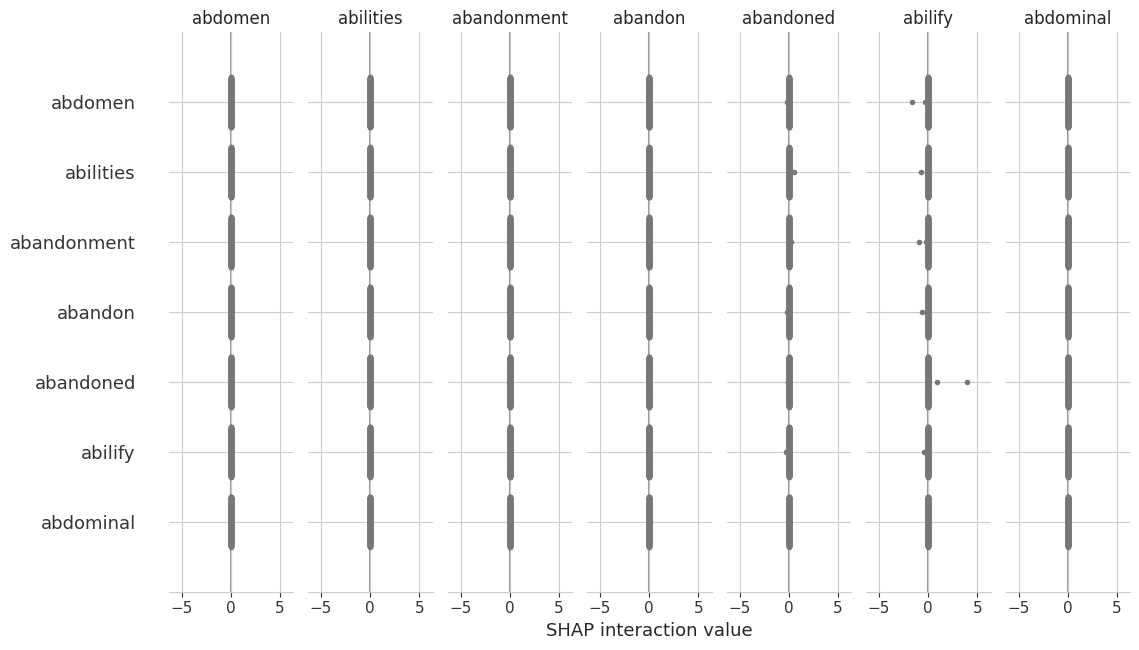

In [ ]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=vectorizer.get_feature_names_out(),
    show=False
)

plt.tight_layout()
plt.show()


In [ ]:
feature_names = vectorizer.get_feature_names_out()

# Assuming shap_values has shape (n_samples, n_features, n_classes)
# To get mean absolute SHAP values per feature, average over samples (axis 0) and classes (axis 2)
mean_abs_shap = np.abs(shap_values).mean(axis=(0, 2))

print(f"Shape of feature_names: {feature_names.shape}")
print(f"Shape of mean_abs_shap: {mean_abs_shap.shape}")

shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

Shape of feature_names: (5000,)
Shape of mean_abs_shap: (5000,)


In [ ]:
top_positive = shap_df.head(30)
top_positive


,feature,mean_abs_shap
1140,depression,0.185906
2203,im,0.171437
1294,dont,0.097950
4808,want,0.083877
2413,just,0.078281
195,anxiety,0.071586
2544,life,0.066827
1660,feel,0.059131
4291,suicide,0.056225
1196,die,0.054840


In [ ]:
top_positive.to_csv("top_lexical_biomarkers.csv", index=False)


In [ ]:
signed_shap = pd.DataFrame({
    "feature": feature_names,
    "mean_shap": shap_values.mean(axis=(0, 2)) # Average across samples (axis=0) and classes (axis=2)
}).sort_values(by="mean_shap", ascending=False)

depression_terms = signed_shap.head(20)
protective_terms = signed_shap.tail(20)

depression_terms, protective_terms

(        feature  mean_shap
 1196        die   0.015666
 4808       want   0.012452
 1138  depressed   0.011921
 4291    suicide   0.009110
 2932    nervous   0.006514
 4507      tired   0.004452
 1991      happy   0.004322
 1660       feel   0.004295
 3481       quot   0.003464
 4290   suicidal   0.002941
 2544       life   0.002796
 2162       hurt   0.002575
 136       alive   0.002473
 2376        ive   0.002391
 2455       know   0.002384
 1961       guys   0.002341
 2947       niki   0.002222
 2818       miss   0.001765
 4614      tweet   0.001715
 474       blood   0.001611,
          feature  mean_shap
 4081       sorry  -0.001954
 2530        lets  -0.001984
 3749          rt  -0.002076
 3928        shit  -0.002534
 4738          ve  -0.002593
 1793     friends  -0.002708
 2416         jyp  -0.002734
 4976         yes  -0.002953
 2593      living  -0.003032
 4224      stress  -0.003266
 2145        http  -0.003284
 3022          oh  -0.003453
 2413        just  -0.003711
 195 

The most influential lexical biomarkers were dominated by negative affect, social isolation, and cognitive rumination. Terms related to emotional exhaustion and loneliness consistently contributed positively toward depression classification, while language associated with social engagement and optimism exhibited protective effects.